In [1]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
# import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

In [2]:
classeses = []
for i in os.listdir('C:/Users/Admin/Desktop/MIE1517_Project/data'):
    if i!=5:
        classeses.append(i)
classeses

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutrality',
 'sadness',
 'surprise']

In [6]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import cv2
import dlib
import numpy as np
import os
from pathlib import Path

# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')


# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

def split_process_dataset(dataset_dir, save_originals_dir, save_combined_dir):
    all_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(dataset_dir) for f in filenames]
    train_val, test_paths = train_test_split(all_images, test_size=0.2, random_state=42)
    train_paths, val_paths = train_test_split(train_val, test_size=0.25, random_state=42)

    train_features, train_labels, val_features, val_labels, failed_indices = [], [], [], [], []

    # Initialize CLAHE outside the loop
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Create subdirectories for each label in both save directories
    for label in classeses:
        os.makedirs(os.path.join(save_originals_dir, label), exist_ok=True)
        os.makedirs(os.path.join(save_combined_dir, label), exist_ok=True)
    # Process images
    for img_path in train_paths + val_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


        gray_clahe = clahe.apply(img)
        faces = detector(gray_clahe, 1)
        if not faces:
            gray_eq = cv2.equalizeHist(img)
            faces = detector(gray_eq, 1)
            gray_clahe = gray_eq if faces else gray_clahe

        if faces:
            face = faces[0]
            landmarks = predictor(gray_clahe, face)
            combined_img = extract_and_combine_regions(gray_clahe, landmarks)

            label = Path(img_path).parent.name
            combined_img_path = os.path.join(save_combined_dir, label, Path(img_path).name)
            cv2.imwrite(combined_img_path, combined_img)

            if img_path in train_paths:
                train_features.append(combined_img)
                train_labels.append(label)
            else:
                val_features.append(combined_img)
                val_labels.append(label)
        else:
            failed_indices.append(img_path)

    # Process test images without modifications
    for img_path in test_paths:
        label = Path(img_path).parent.name
        test_img_path = os.path.join(save_originals_dir, 'test', label, Path(img_path).name)
        cv2.imwrite(test_img_path, img)

    return train_features, train_labels, val_features, val_labels, failed_indices, test_paths

# Preprocess and transform the images
transform = transforms.Compose([transforms.ToTensor()])

# Main processing
dataset_directory = 'C:/Users/Admin/Desktop/MIE1517_Project/data'
save_originals_directory = 'C:/Users/Admin/Desktop/MIE1517_Project/saved_original'
save_combined_directory = 'C:/Users/Admin/Desktop/MIE1517_Project/saved_combined'

train_features, train_labels, val_features, val_labels, failed_indices, test_paths = split_process_dataset(
    dataset_directory, save_originals_directory, save_combined_directory
)

In [7]:
# Convert processed images into tensors and apply transforms
def prepare_dataset(images, labels, transform):
    # If labels are strings, convert to integers using a mapping
    if labels and isinstance(labels[0], str):
        # Create a mapping from class names to integers
        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(set(labels)))}
        # Convert class names to indices
        labels = [class_to_idx[cls_name] for cls_name in labels]
    
    # If labels are nested lists, flatten them
    if labels and isinstance(labels[0], list):
        labels = [item for sublist in labels for item in sublist]
    
    tensor_images = [transform(Image.fromarray(image)) if not isinstance(image, Image.Image) else transform(image) for image in images]
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    
    return TensorDataset(torch.stack(tensor_images), tensor_labels)

In [8]:
# Prepare datasets for combined regions
train_dataset = prepare_dataset(train_features, train_labels, transform)
val_dataset = prepare_dataset(val_features, val_labels, transform)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [9]:
class CNNetResidual(nn.Module):
    def __init__(self, num_classes=8, num_in_channels=1):
        super().__init__()

        # Downward path
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, 32, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32, 64)
        )

        self.downconv2 = nn.Sequential(
            nn.Conv2d(96, 128, kernel_size=7, padding=1,stride = 2),  # Fix the number of input channels
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(128, 256)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(384 * 13 * 13, 1024),  # Adjust the input size here
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

        self.name = "CNNetResidual"

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)

        out = out.view(out.size(0), -1)  # Flatten before passing to fully connected layers
        out = self.fc_layers(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        # First 1x1 Convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu1 = nn.ReLU()

        # Second 3x3 Convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x

        # Main Path
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))

        # Skip Connection
        out = torch.cat([out, identity], dim=1)
        out = F.relu(out)
        return out

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CombinedCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate = 0.3):
        super(CombinedCNN, self).__init__()
        self.name = "CombinedCNN"

        # Define convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Assuming input channels = 1 (grayscale)
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),
        )

        # Define fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512 * 7 * 7)

        # Apply fully connected layers
        x = self.fc_layers(x)

        return x

num_classes = 8
combined_model = CombinedCNN(num_classes)

In [10]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def evaluate_and_predict(model, loader):
    """ Evaluate the network and predict labels """
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    accuracy = correct / total
    return accuracy, all_predicted, all_labels

In [11]:
import time
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=300):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    model_checkpoint_path = 'C:/Users/Admin/Desktop/MIE1517_Project/output'

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    print("Training Begin...\n")
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy_val, _, _ = evaluate_and_predict(model, train_loader)
        train_accuracy[epoch] = train_accuracy_val

        model.eval()
        valid_loss = 0.0
        for inputs, labels in val_loader:
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy_val, _, _ = evaluate_and_predict(model, val_loader)
        validation_accuracy[epoch] = validation_accuracy_val

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.6f}, Train Loss: {train_losses[epoch]:.6f} | "
              f"Val Acc: {validation_accuracy[epoch]:.6f}, Val Loss: {validation_losses[epoch]:.6f}")

        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), f"{model_path}.pt")

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")
    
    # Compute the confusion matrix after the final epoch
    _, val_predicted, val_labels = evaluate_and_predict(model, val_loader)
    cm = confusion_matrix(val_labels, val_predicted)
    class_names = list(classeses)  # Replace with your class names
    cm_figure = plot_confusion_matrix(cm, class_names)
    plt.show()
    
    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title("Training and Validation Loss")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracy, validation_losses, validation_accuracy

Training Begin...

Epoch 1: Train Acc: 0.275771, Train Loss: 1.867565 | Val Acc: 0.279946, Val Loss: 2.018079
Epoch 2: Train Acc: 0.382819, Train Loss: 1.657212 | Val Acc: 0.374159, Val Loss: 1.862861
Epoch 3: Train Acc: 0.485903, Train Loss: 1.565515 | Val Acc: 0.429341, Val Loss: 1.664145
Epoch 4: Train Acc: 0.518502, Train Loss: 1.471580 | Val Acc: 0.422611, Val Loss: 1.578587
Epoch 5: Train Acc: 0.558590, Train Loss: 1.386215 | Val Acc: 0.448183, Val Loss: 1.554925
Epoch 6: Train Acc: 0.606167, Train Loss: 1.340476 | Val Acc: 0.449529, Val Loss: 1.527492
Epoch 7: Train Acc: 0.627313, Train Loss: 1.248366 | Val Acc: 0.437416, Val Loss: 1.534866
Epoch 8: Train Acc: 0.655066, Train Loss: 1.169457 | Val Acc: 0.448183, Val Loss: 1.532215
Epoch 9: Train Acc: 0.698238, Train Loss: 1.119237 | Val Acc: 0.441454, Val Loss: 1.523855
Epoch 10: Train Acc: 0.755947, Train Loss: 1.033999 | Val Acc: 0.458950, Val Loss: 1.521816
Epoch 11: Train Acc: 0.751982, Train Loss: 0.951133 | Val Acc: 0.45895

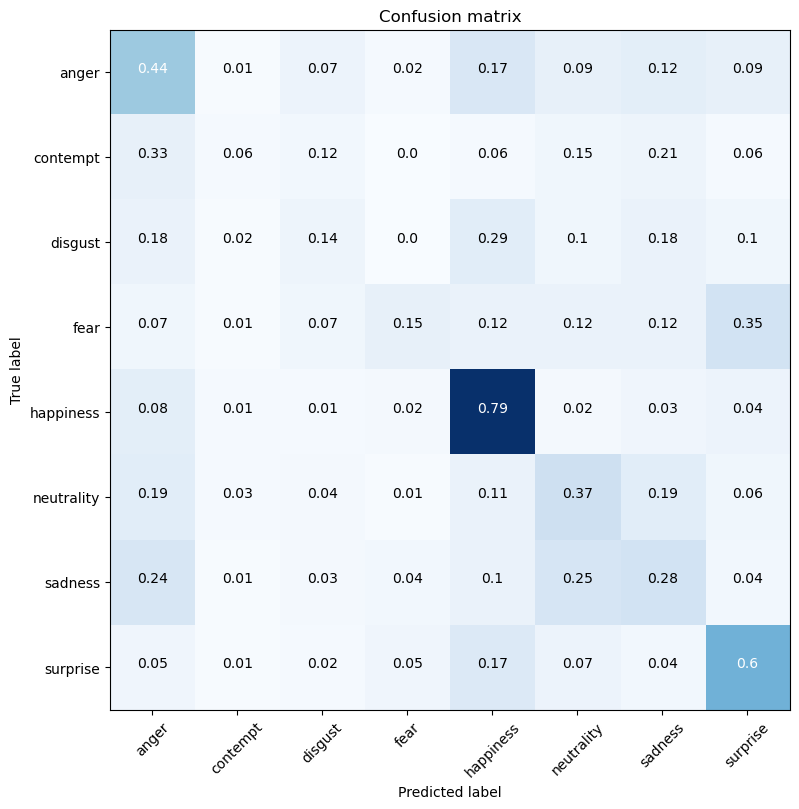

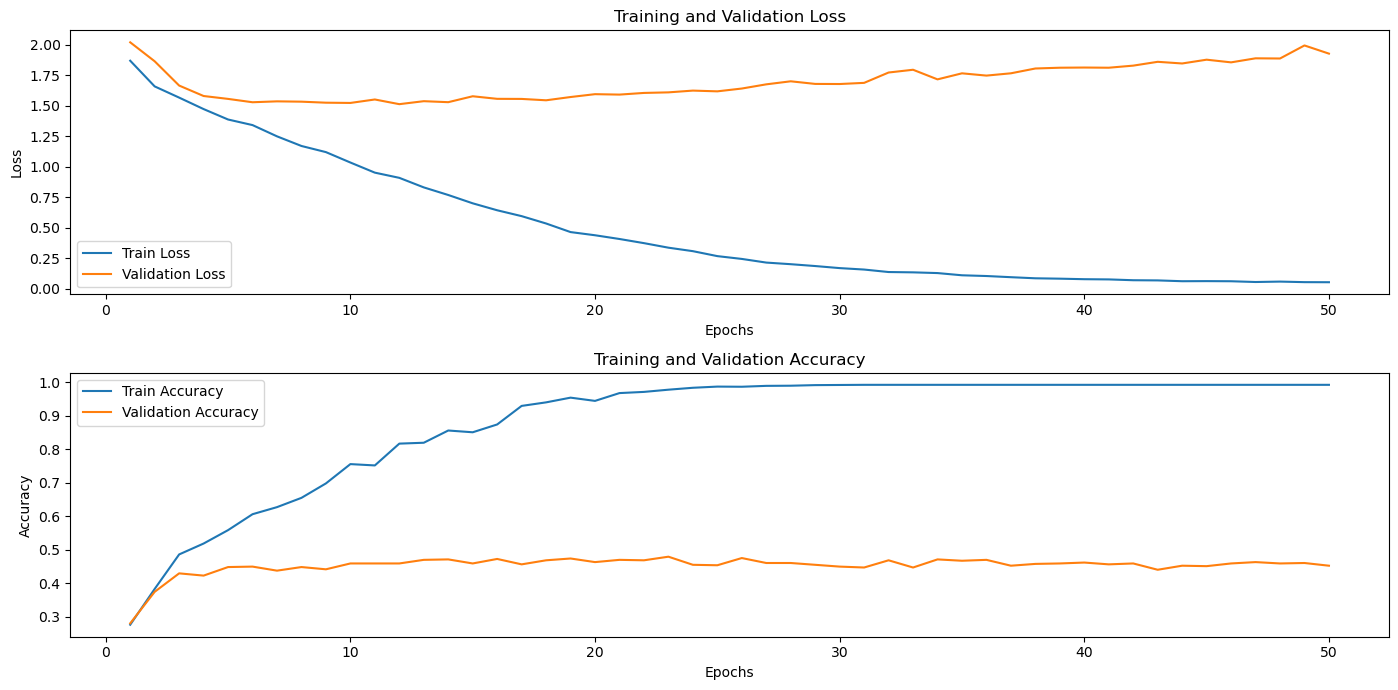

In [12]:
use_cuda = True
combined_model = CNNetResidual(8)
combined_model = combined_model.cuda()
Model1 = trainmodel(combined_model, train_dataset, val_dataset, batch=128, learningRate=2e-5, num_epochs=50)